<a href="https://colab.research.google.com/github/iamatul1214/LLMs/blob/main/Multihead_attention_illustration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook contains two examples of multihead attention. one with simple numpy and another with simple transformer using keras.

### 1. Simple Numpy example

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 1. TOY INPUT EMBEDDINGS (3 tokens, dimension 4)
# ----------------------------------------------------------
tokens = ["I", "love", "pizza"]

X = np.array([
    [1.0, 0.0, 1.0, 0.0],   # "I"
    [0.0, 1.0, 0.0, 1.0],   # "love"
    [1.0, 1.0, 0.0, 0.0]    # "pizza"
])

# ----------------------------------------------------------
# 2. PROJECTION MATRICES FOR 2 HEADS
# ----------------------------------------------------------
W_Q1 = np.array([[1,0],[0,1],[1,0],[0,1]])
W_K1 = np.array([[1,0],[1,0],[0,1],[0,1]])
W_V1 = np.array([[1,0],[0,1],[1,0],[0,1]])

W_Q2 = np.array([[0,1],[1,0],[0,1],[1,0]])
W_K2 = np.array([[1,1],[0,1],[1,0],[0,1]])
W_V2 = np.array([[0,1],[1,0],[1,1],[0,1]])

def softmax(x):
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def attention(Q, K, V):
    scores = Q @ K.T / np.sqrt(Q.shape[1])  # scaled dot-product
    weights = np.array([softmax(row) for row in scores])
    out = weights @ V
    return weights, out

# ----------------------------------------------------------
# 3. Compute Q, K, V and Attention for each head
# ----------------------------------------------------------
Q1, K1, V1 = X @ W_Q1, X @ W_K1, X @ W_V1
Q2, K2, V2 = X @ W_Q2, X @ W_K2, X @ W_V2

weights1, out1 = attention(Q1, K1, V1)
weights2, out2 = attention(Q2, K2, V2)

# ----------------------------------------------------------
# 4. PLOTTING FUNCTIONS
# ----------------------------------------------------------
def plot_attention_heatmap(attention_weights, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.matshow(attention_weights, cmap="viridis")
    fig.colorbar(cax)

    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45)
    ax.set_yticklabels(tokens)

    ax.set_title(title)
    plt.show()


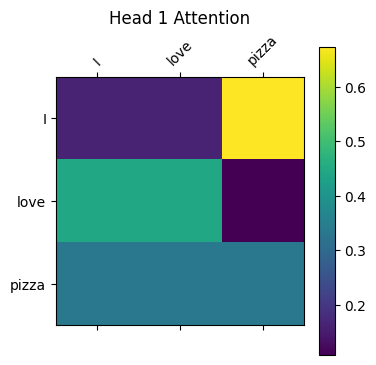

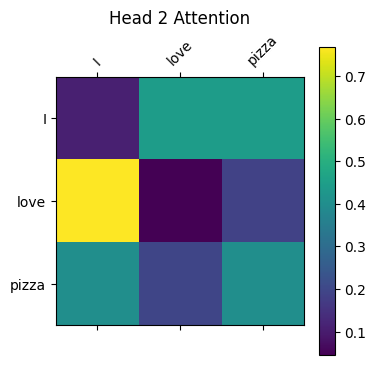

In [2]:
# ----------------------------------------------------------
# 5. SHOW EACH HEAD'S ATTENTION
# ----------------------------------------------------------
plot_attention_heatmap(weights1, "Head 1 Attention")
plot_attention_heatmap(weights2, "Head 2 Attention")

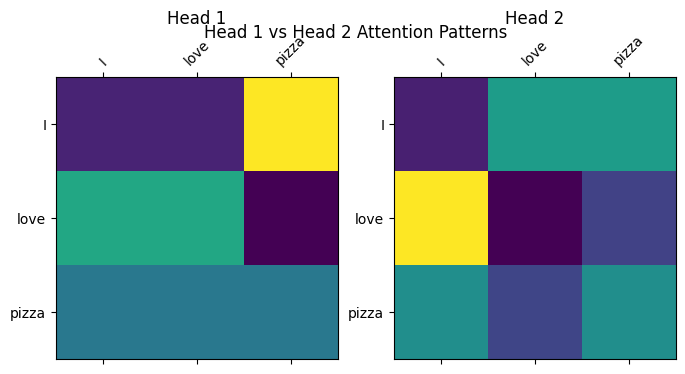

In [3]:
# ----------------------------------------------------------
# 6. SIDE-BY-SIDE COMPARISON
# ----------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].matshow(weights1, cmap="viridis")
axs[0].set_title("Head 1")
axs[0].set_xticks(range(len(tokens)))
axs[0].set_yticks(range(len(tokens)))
axs[0].set_xticklabels(tokens, rotation=45)
axs[0].set_yticklabels(tokens)

axs[1].matshow(weights2, cmap="viridis")
axs[1].set_title("Head 2")
axs[1].set_xticks(range(len(tokens)))
axs[1].set_yticks(range(len(tokens)))
axs[1].set_xticklabels(tokens, rotation=45)
axs[1].set_yticklabels(tokens)

plt.suptitle("Head 1 vs Head 2 Attention Patterns")
plt.show()

## 1. Queries, Keys, Values are just linear transforms, we just compute
```
Q = X @ W_Q
K = X @ W_K
V = X @ W_V
```
## 2. Attention is just dot-products + softmax
```
attention_scores = Q @ K.T
attention_weights = softmax(scores)
output = weights @ V
```
## 3. Multi-head = same operation but in parallel with different projections

- Head 1 focuses on one type of relationship

- Head 2 focuses on another

## 4. This is the intuition behind:

- syntactic heads

- semantic heads

- positional heads

- long-range dependency heads


## Now let's do the same experiment with a tensorflow tiny/toy custom structured transformer

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# ---------------------------
# 1) USER INPUT & TOKENIZER
# ---------------------------
sentence = input("Enter a short sentence (3-10 words recommended):\n> ").strip()
tokens = sentence.split()
if len(tokens) < 2:
    raise ValueError("Please enter at least 2 tokens (words).")

vocab = list(dict.fromkeys(tokens))   # preserve order, unique tokens
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}

# convert to indices, shape (1, seq_len)
idxs = np.array([[stoi[w] for w in tokens]], dtype=np.int32)
print("Token ids:", idxs)
vocab_size = len(vocab)
seq_len = idxs.shape[1]

# Prepare inputs and targets for next-token prediction
# Input:  tokens[0..N-2], Target: tokens[1..N-1]
inputs = idxs[:, :-1]   # shape (1, seq_len-1)
targets = idxs[:, 1:]   # shape (1, seq_len-1)
timesteps = inputs.shape[1]

# -----------------------------------
# 2) A CUSTOM TINY TRANSFORMER MODEL
# -----------------------------------
class TinyTFTransformer(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim=32, num_heads=4, ff_dim=64):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        # A small feed-forward that maps embed_dim -> vocab_size (logits)
        self.ff = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(embed_dim),
            tf.keras.layers.Dense(vocab_size)   # final logits per token
        ])

    def call(self, x, training=False, return_attention_scores=False):
        # x: (batch, seq, )
        emb = self.embed(x)                         # (batch, seq, embed_dim)
        # Use self-attention: query=key=value=emb
        # Keras MHA returns (attn_output) normally. We'll request scores explicitly below by using
        # the functional form in training loop to get scores with return_attention_scores=True.
        att_out = self.mha(query=emb, value=emb, key=emb, return_attention_scores=False)
        logits = self.ff(att_out)                   # (batch, seq, vocab_size)
        return logits

# We will call mha directly in training loop with return_attention_scores=True to fetch scores.
model = TinyTFTransformer(vocab_size=vocab_size, embed_dim=32, num_heads=4, ff_dim=64)

# Build model (call once)
_ = model(tf.constant(inputs))

# ---------------------------
# 3) TRAINING SETUP
# ---------------------------
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(1e-3)

# We'll do a small custom loop and also capture attention scores using the MHA layer directly.
num_steps = 350

print("\nTraining for next-token prediction on your sentence...")
for step in range(num_steps):
    with tf.GradientTape() as tape:
        emb = model.embed(inputs)  # (1, timesteps, embed_dim)
        # Use MHA with return_attention_scores=True
        att_out, att_scores = model.mha(query=emb, value=emb, key=emb, return_attention_scores=True)
        logits = model.ff(att_out)  # (1, timesteps, vocab_size)
        loss = loss_fn(targets, logits)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    if step % 50 == 0:
        print(f"Step {step:4d}  loss = {loss.numpy():.4f}")

print("Training finished. Final loss:", loss.numpy())


Enter a short sentence (3-10 words recommended):
> The man jumped from the boat
Token ids: [[0 1 2 3 4 5]]

Training for next-token prediction on your sentence...
Step    0  loss = 1.7916
Step   50  loss = 1.6097
Step  100  loss = 1.6095
Step  150  loss = 1.6094
Step  200  loss = 1.6093
Step  250  loss = 0.7680
Step  300  loss = 0.0002
Training finished. Final loss: 4.887281e-05


In [40]:
# ---------------------------
# 4) EXTRACT ATTENTION SCORES
# ---------------------------
# att_scores shape: (batch, num_heads, target_seq_len, source_seq_len)
emb = model.embed(inputs)
att_out, att_scores = model.mha(query=emb, value=emb, key=emb, return_attention_scores=True)
att_scores = att_scores.numpy()  # convert to numpy
# squeeze batch dimension (batch size = 1)
att_scores = np.squeeze(att_scores, axis=0)    # (num_heads, timesteps, timesteps)

num_heads = att_scores.shape[0]
att_scores

array([[[1.77795455e-01, 3.09093237e-01, 2.67399639e-01, 9.46154892e-02,
         1.51096106e-01],
        [6.99228495e-02, 5.46533108e-01, 3.55441839e-01, 4.94998507e-03,
         2.31523011e-02],
        [6.96936250e-02, 5.51568091e-01, 3.47000271e-01, 5.29987272e-03,
         2.64380332e-02],
        [1.39558658e-01, 5.86726367e-02, 6.78183660e-02, 4.71227974e-01,
         2.62722373e-01],
        [2.03716025e-01, 1.78825065e-01, 1.87153548e-01, 2.29011193e-01,
         2.01294228e-01]],

       [[6.64076209e-02, 5.53982735e-01, 2.41135582e-01, 1.28104426e-02,
         1.25663534e-01],
        [2.03069568e-01, 7.54965544e-02, 1.10755548e-01, 4.51884449e-01,
         1.58793867e-01],
        [1.22840255e-01, 3.95832837e-01, 2.49431118e-01, 5.06689288e-02,
         1.81226879e-01],
        [7.02900887e-02, 5.47199011e-01, 2.45933905e-01, 1.37853092e-02,
         1.22791700e-01],
        [6.02176189e-02, 1.79650669e-03, 7.12110801e-03, 9.10194874e-01,
         2.06698794e-02]],

      

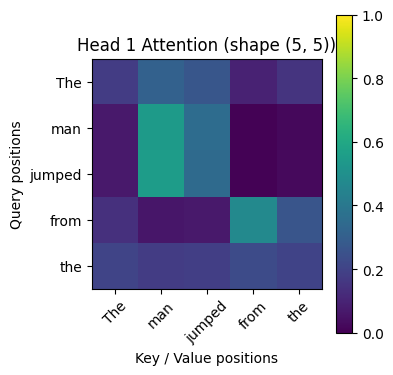

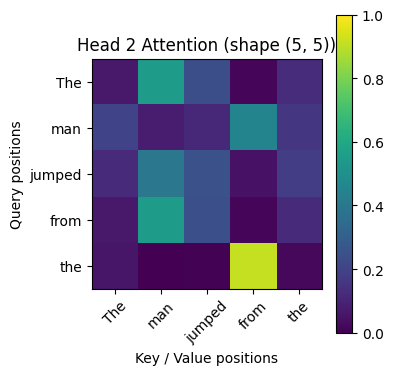

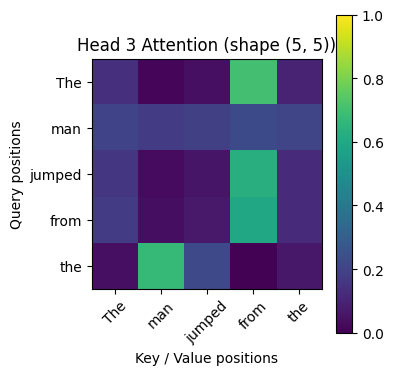

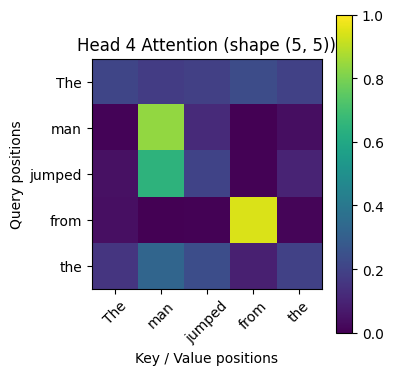

In [41]:
# ---------------------------
# 5) VISUALIZE ATTENTION HEATMAPS
# ---------------------------
labels = tokens[:-1]   # labels correspond to timesteps (inputs)
for h in range(num_heads):
    plt.figure(figsize=(4,4))
    plt.imshow(att_scores[h], cmap='viridis', vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f"Head {h+1} Attention (shape {att_scores[h].shape})")
    plt.xticks(range(timesteps), labels, rotation=45)
    plt.yticks(range(timesteps), labels)
    plt.xlabel("Key / Value positions")
    plt.ylabel("Query positions")
    plt.tight_layout()
    plt.show()

In [42]:
# ---------------------------
# 6) OPTIONAL: print probabilities for a chosen step
# ---------------------------
# Compute final logits & softmax for the first time-step
final_logits = logits.numpy()[0]   # (timesteps, vocab_size)
# show softmax for first query position
import scipy.special
probs_first_pos = scipy.special.softmax(final_logits[0])
print("\nVocabulary:", vocab)
print("Probabilities for first prediction (softmax of logits) at query position 0:")
for w,p in zip(vocab, probs_first_pos):
    print(f"  {w:10s}: {p:.4f}")


Vocabulary: ['The', 'man', 'jumped', 'from', 'the', 'boat']
Probabilities for first prediction (softmax of logits) at query position 0:
  The       : 0.0000
  man       : 0.9999
  jumped    : 0.0000
  from      : 0.0001
  the       : 0.0000
  boat      : 0.0000


In [43]:
# ---------------------
# LOOP AND CHECK THE LOGITS FOR EACH TOKEN
# ---------------------
final_logits = logits.numpy()[0]   # (timesteps, vocab_size)
for step in range(timesteps):
  # show softmax for ith query position
  probs_first_pos = scipy.special.softmax(final_logits[step])
  print("\nVocabulary:", vocab)
  print(f"Probabilities for first prediction (softmax of logits) at query position {step}:")
  for w,p in zip(vocab, probs_first_pos):
      print(f"  {w:10s}: {p:.4f}")


Vocabulary: ['The', 'man', 'jumped', 'from', 'the', 'boat']
Probabilities for first prediction (softmax of logits) at query position 0:
  The       : 0.0000
  man       : 0.9999
  jumped    : 0.0000
  from      : 0.0001
  the       : 0.0000
  boat      : 0.0000

Vocabulary: ['The', 'man', 'jumped', 'from', 'the', 'boat']
Probabilities for first prediction (softmax of logits) at query position 1:
  The       : 0.0000
  man       : 0.0000
  jumped    : 1.0000
  from      : 0.0000
  the       : 0.0000
  boat      : 0.0000

Vocabulary: ['The', 'man', 'jumped', 'from', 'the', 'boat']
Probabilities for first prediction (softmax of logits) at query position 2:
  The       : 0.0000
  man       : 0.0001
  jumped    : 0.0000
  from      : 0.9999
  the       : 0.0000
  boat      : 0.0000

Vocabulary: ['The', 'man', 'jumped', 'from', 'the', 'boat']
Probabilities for first prediction (softmax of logits) at query position 3:
  The       : 0.0000
  man       : 0.0000
  jumped    : 0.0000
  from     